In [11]:
## April 6 2017
## jefan
## GOAL: compute between-run similarity matrix in order to compare between-obj and within-obj similarity to test 
## for differentiation. Use run-wise map of betas from GLM for each object.
import warnings
warnings.filterwarnings('ignore')

In [3]:
## import general modules
import numpy as np
import glob
import os
import scipy.stats as stats
from sklearn import metrics
import matplotlib
matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *

## import imaging analysis specific modules
import brainiak
import nilearn
import nibabel



In [4]:
## get list of subject directories
proj_dir = '/home/jefan/sketchloop02'
contents_dir = os.listdir(proj_dir)

sub_dirs = []
for i in contents_dir:
    if i.split('_')[1]=='neurosketch':
        sub_dirs.append(i)

sub_dirs = sorted(sub_dirs)
print(sub_dirs)

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1201161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207161_neurosketch', '1207162_neurosketch']


In [5]:
# do for single subject for now
s = sub_dirs[0]

In [6]:
analysis1_path = os.path.join(s,'analysis','firstlevel')
analysis1_dirs = os.listdir(analysis1_path)
if 'glm4_recognition_run_1+.feat' in analysis1_dirs:
    print('Check to make sure you get rid of redundant/incomplete GLM folders for this subject')
print(sorted(analysis1_dirs))

['.gitignore', 'glm4_recognition_run_1.feat', 'glm4_recognition_run_2.feat', 'glm4_recognition_run_3.feat', 'glm4_recognition_run_4.feat', 'glm4_recognition_run_5.feat', 'glm4_recognition_run_6.feat', 'preproc_recognition_run_1.feat', 'preproc_recognition_run_2.feat', 'preproc_recognition_run_3.feat', 'preproc_recognition_run_4.feat', 'preproc_recognition_run_5.feat', 'preproc_recognition_run_6.feat', 'rois']


In [7]:
## glm output directories by run number
pre1 = 'glm4_recognition_run_3.feat'
pre2 = 'glm4_recognition_run_4.feat'
post1 = 'glm4_recognition_run_5.feat'
post2 = 'glm4_recognition_run_6.feat'

In [8]:
stats_path = os.path.join(s,'analysis','firstlevel',pre1,'stats')
contents_stats_dir = os.listdir(stats_path)
print(sorted(contents_stats_dir))

['cope1.nii.gz', 'cope2.nii.gz', 'cope3.nii.gz', 'cope4.nii.gz', 'dof', 'logfile', 'pe1.nii.gz', 'pe2.nii.gz', 'pe3.nii.gz', 'pe4.nii.gz', 'pe5.nii.gz', 'pe6.nii.gz', 'pe7.nii.gz', 'pe8.nii.gz', 'res4d.nii.gz', 'sigmasquareds.nii.gz', 'smoothness', 'threshac1.nii.gz', 'tstat1.nii.gz', 'tstat2.nii.gz', 'tstat3.nii.gz', 'tstat4.nii.gz', 'varcope1.nii.gz', 'varcope2.nii.gz', 'varcope3.nii.gz', 'varcope4.nii.gz', 'zstat1.nii.gz', 'zstat2.nii.gz', 'zstat3.nii.gz', 'zstat4.nii.gz']


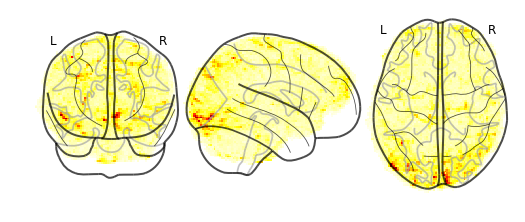

In [12]:
from nilearn import image
from nilearn import plotting
nifti_path = os.path.join(s,'analysis','firstlevel',pre1,'stats','cope1.nii.gz')
plotting.plot_glass_brain(nifti_path)

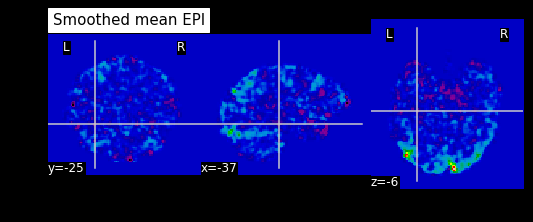

In [13]:
fmri_img = image.smooth_img(nifti_path,fwhm=3)
from nilearn.plotting import plot_epi
mean_img = image.mean_img(fmri_img)
plot_epi(mean_img, title='Smoothed mean EPI', cut_coords=[-37,-25,-6])

In [17]:
## load ROI mask
rois_path = os.path.join(s,'analysis','firstlevel','rois')
contents_rois = os.listdir(rois_path)
# print(sorted(contents_rois))

#### helper functions

In [ ]:
## cope numbering legend
## cope1 = 'bed'
## cope2 = 'bench'
## cope3 = 'chair'
## cope4 = 'table'

def triple_sum(X):
    return sum(sum(sum(X)))
    
def load_roi_mask(subj,run_num,roi):
    mask_path = '../data/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_run_' + str(run_num) + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def load_regressor(subj):
    regressor_path = '../regressor/' + subj + '.csv'
    regressor = tb.tabarray(SVfile=regressor_path)   
    return regressor

def normalize(X):
    mn = X.mean(0)
    sd = X.std(0)
    X = X - mn
    X = X / np.maximum(sd, 1e-5)
    return X

def load_single_run_weights(subj,run_num,cope_num):
    nifti_path = subj + '/analysis/firstlevel/glm4_recognition_run_' + str(run_num) + \
                '.feat/stats/' + 'cope' + str(cope_num) + '.nii.gz'

def load_single_run(subj,run_num):    
    nifti_path = '../data/' + subj + '/analysis/firstlevel/preproc_recognition_run_' + str(run_num) + '.feat/filtered_func_data.nii.gz'
    fmri_img = image.load_img(nifti_path)
    fmri_data = fmri_img.get_data()    
    return fmri_data

def get_mask_array(mask_path):
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels

def load_run_dataset(subj,run_num,roi):
    # load functional timeseries
    nifti_path = '../data/' + subj + '/analysis/firstlevel/preproc_recognition_run_' + str(run_num) + '.feat/filtered_func_data.nii.gz'
    # load combined mask
    if run_num<=2:
        mask_path = '../data/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_12_binarized.nii.gz'
    elif (run_num>2) & (run_num<=4):
        mask_path = '../data/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_34_binarized.nii.gz'
    elif (run_num>4):
        mask_path = '../data/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_56_binarized.nii.gz'
    else:
        mask_path = '../data/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_run_' + str(run_num) + '_binarized.nii.gz'
    # load regressor
    regressor = load_regressor(subj)
    R = regressor[regressor['run_num']==run_num]
    # extract object labels (attr.targets)
    objs = R['object']
    objs[R['onset']==0] = 0    ## eliminate object labels where stim NOT onscreen
    targets = list(objs)
    # define chunks as different repetitions of same object    
    uniq_objs = np.unique(objs[objs !=0])
    tmp = np.zeros(len(objs))
    for u in uniq_objs:
        matches = [inds for (inds,vals) in list(enumerate(objs)) if vals==u]
        for (i,j) in enumerate(matches):
            tmp[j] = i    
    chunks = tmp        
    ds = fmri_dataset(samples=nifti_path, chunks=chunks,
                      targets=targets, mask=mask_path)
    return ds

def concat_masks(x,y):
    extra_dim = len(x.shape)
    return np.concatenate((np.expand_dims(x,extra_dim),np.expand_dims(y,extra_dim)),axis=extra_dim)

def average_across_reps(ds):
    Xmean = []
    for i in range(1,5):
        t0 = np.where(ds1.targets==i)
        t1 = t0[0]+4
        tmp = np.zeros(len(ds1.targets)).astype(bool)
        tmp[t1] = True                
        raw = ds.samples[tmp].mean(0)
        if len(Xmean)==0:
            Xmean = raw
        else:
            Xmean = np.vstack((Xmean,raw))
    return Xmean
